## 6-7. 프로젝트: 멋진 작사가 만들기

#### 라이브러리 버전을 확인해 봅니다

In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


### Step 1. 데이터 다운로드

이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면, ~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.

### Step 2. 데이터 읽어오기

glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

In [2]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' 
txt_list = glob.glob(txt_file_path)
print('txt_list',len(txt_list), txt_list[:10])

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() 
        raw_corpus.extend(raw) 

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:5])


txt_list 49 ['/aiffel/aiffel/lyricist/data/lyrics/michael-jackson.txt', '/aiffel/aiffel/lyricist/data/lyrics/blink-182.txt', '/aiffel/aiffel/lyricist/data/lyrics/nursery_rhymes.txt', '/aiffel/aiffel/lyricist/data/lyrics/jimi-hendrix.txt', '/aiffel/aiffel/lyricist/data/lyrics/eminem.txt', '/aiffel/aiffel/lyricist/data/lyrics/al-green.txt', '/aiffel/aiffel/lyricist/data/lyrics/cake.txt', '/aiffel/aiffel/lyricist/data/lyrics/bob-dylan.txt', '/aiffel/aiffel/lyricist/data/lyrics/bjork.txt', '/aiffel/aiffel/lyricist/data/lyrics/leonard-cohen.txt']
데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]', 'You ever want something ', "that you know you shouldn't have "]


In [3]:
print("Examples:\n", raw_corpus[:10])
for x in raw_corpus[:5]:
    print('U x',x)
    if len(x)==0:
        continue
    if x[-1]==']':
        print('D x','')
        continue
    print('OK',x)    

Examples:
 ['', '', '[Spoken Intro:]', 'You ever want something ', "that you know you shouldn't have ", "The more you know you shouldn't have it, ", 'The more you want it ', 'And then one day you get it, ', "It's so good too ", "But it's just like my girl "]
U x 
U x 
U x [Spoken Intro:]
D x 
U x You ever want something 
OK You ever want something 
U x that you know you shouldn't have 
OK that you know you shouldn't have 


### Step 3. 데이터 정제

앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

그래서, tf.keras.preprocessing.sequence.pad_sequences()메소드의 maxlen=15 할 예정입니다.

In [4]:
# enumerate() 함수를 이용하여 raw_corpus list 내에 저장된 문장과 그 문장의 인덱스를 반환 (인덱스, 문장 순)
# 원치않는 문장:화자가 표기된 문장,공백인 문장 제외
import re 

for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-2] == ":" or sentence[-1] == "]":
        continue  # 문장의 끝이 ], 끝에서 두번째가 : 인 문장은 건너뜁니다.
    if idx > 10: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 
When she's around me 


In [5]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2   # \1 : 1~9사이가능,  숫자는 그룹을 나타냄 
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [6]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 위에서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

### Step 4. 평가 데이터셋 분리

훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [7]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다

def tokenize(corpus):
    # 15000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 15000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    # maxlen = 15, 입력 데이터의 시퀀스 길이를  15개로 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen=15, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   5   34   45 ... 1161  143    3]
 [   5   34   45 ... 1161  143    3]] <keras_preprocessing.text.Tokenizer object at 0x7f1581824e50>


In [8]:
print(tensor.shape, tensor[:3, :15])

(175749, 15) [[   2 2701 2584    3    0    0    0    0    0    0    0    0    0    0
     0]
 [   2    7  156   62  199    3    0    0    0    0    0    0    0    0
     0]
 [   2   17    7   34    7 1518   15   76    3    0    0    0    0    0
     0]]


In [9]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [10]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.

src_input = tensor[:, :-1]  

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])



[   2 2701 2584    3    0    0    0    0    0    0    0    0    0    0]
[2701 2584    3    0    0    0    0    0    0    0    0    0    0    0]


In [11]:
# train, test 분리: 0.8:0.2
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val= train_test_split(src_input,tgt_input, test_size=0.2, random_state=7)
print(enc_train.shape, enc_val.shape, dec_train.shape, dec_val.shape )


(140599, 14) (35150, 14) (140599, 14) (35150, 14)


In [12]:
### 하이퍼 파라메터들 설정

BATCH_SIZE = 128 #256
embedding_size = 1024 #1024 #512 # 256 
hidden_size = 2048 #1024 
lr = 0.001 #0.001 

BUFFER_SIZE = len(enc_train)
steps_per_epoch = len(enc_train) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1  
print(BUFFER_SIZE,steps_per_epoch,VOCAB_SIZE)

140599 1098 15001


### Step 5. 인공지능 만들기

모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!

잘 설계한 모델을 학습하려면, model.fit() 함수를 사용해야 합니다. model.fit() 함수에는 다양한 인자를 넣어주어야 하는데, 가장 기본적인 인자로는 데이터셋과 epochs가 있습니다. '5. 실습 (2) 인공지능 학습시키기'에서의 예시와 같이 말이죠.



In [13]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.batchnormal_0 = tf.keras.layers.BatchNormalization()
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) 
        self.batchnormal_1 = tf.keras.layers.BatchNormalization()
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.batchnormal_2 = tf.keras.layers.BatchNormalization()
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        #out = self.batchnormal_0(out)
        out = self.rnn_1(out)
        #out = self.batchnormal_1(out)
        out = self.rnn_2(out)
        #out = self.batchnormal_2(out)
        out = self.linear(out)
        
        return out

lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [15]:
# 배치1개로 모델 입력해봄
enc_train_sample = enc_train[:BATCH_SIZE]
lyricist(enc_train_sample)


<tf.Tensor: shape=(128, 14, 15001), dtype=float32, numpy=
array([[[-8.3756713e-05, -3.7794863e-04,  5.1459003e-05, ...,
         -3.3421817e-05,  1.4434472e-05, -1.3647269e-04],
        [ 9.9452875e-05, -8.5770484e-04, -1.8902957e-04, ...,
          8.7153858e-06, -4.7316196e-05, -2.3816411e-04],
        [ 3.4091121e-04, -1.1964323e-03, -3.0462371e-04, ...,
         -5.3052965e-04,  3.5155041e-04,  3.3987648e-04],
        ...,
        [ 2.0194899e-03,  2.2676219e-03, -1.6849788e-03, ...,
         -1.1314331e-03, -1.1915958e-04,  8.7994558e-04],
        [ 2.1806210e-03,  2.8568129e-03, -2.1170930e-03, ...,
         -9.4553147e-04, -3.3915110e-04,  1.0571892e-03],
        [ 2.2428269e-03,  3.4472137e-03, -2.5356647e-03, ...,
         -7.4828556e-04, -5.5131776e-04,  1.1510400e-03]],

       [[-8.3756713e-05, -3.7794863e-04,  5.1459003e-05, ...,
         -3.3421817e-05,  1.4434472e-05, -1.3647269e-04],
        [-2.3874566e-04, -8.1688326e-05, -2.9921832e-06, ...,
          2.5945759e-04, 

In [16]:
# 모델의 구조를 확인합니다.
lyricist.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  15361024  
_________________________________________________________________
batch_normalization (BatchNo multiple                  0 (unused)
_________________________________________________________________
lstm (LSTM)                  multiple                  25174016  
_________________________________________________________________
batch_normalization_1 (Batch multiple                  0 (unused)
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
batch_normalization_2 (Batch multiple                  0 (unused)
_________________________________________________________________
dense (Dense)                multiple               

하지만 model.fit() 함수의 epochs를 아무리 크게 넣는다 해도 val_loss 값은 2.2 아래로 떨어지지 않습니다. 이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도 있습니다. 자세한 내용은 https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit 를 참고하세요!

Loss는 아래 제시된 Loss 함수를 그대로 사용하세요!

In [17]:
# 학습
optimizer = tf.keras.optimizers.Adam(learning_rate=lr) #0.01) # 0.001
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True.


# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
lyricist.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
history = lyricist.fit(enc_train, dec_train, batch_size=BATCH_SIZE,  validation_data = (enc_val, dec_val), epochs=5) 
          


Epoch 1/5
1099/1099 [==============================] - 357s 321ms/step - loss: 3.2927 - val_loss: 2.9167
Epoch 2/5
1099/1099 [==============================] - 342s 311ms/step - loss: 2.6627 - val_loss: 2.6156
Epoch 3/5
1099/1099 [==============================] - 341s 311ms/step - loss: 2.2123 - val_loss: 2.4361
Epoch 4/5
1099/1099 [==============================] - 341s 310ms/step - loss: 1.8119 - val_loss: 2.3362
Epoch 5/5
1099/1099 [==============================] - 354s 322ms/step - loss: 1.4869 - val_loss: 2.2923


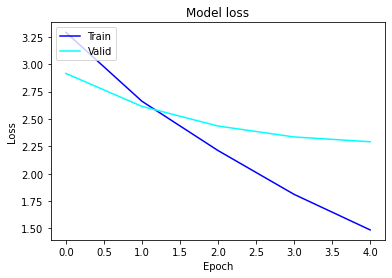

In [18]:
import matplotlib.pyplot as plt
# 훈련 과정 시각화 (loss): train, valid
plt.plot(history.history['loss'],'blue')
plt.plot(history.history['val_loss'],'cyan')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()     


In [19]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start> you", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

데이터가 커서 훈련하는 데 시간이 제법 걸릴 겁니다. 여유를 가지고 작업하시면 좋아요 :)

마지막으로 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!

In [20]:
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i love you so much <end> '

### Q4. 모델이 생성한 가사 한 줄을 제출하세요.

In [ ]:
'<start> i love you so much <end> '

## 회고

본 프로젝트는 Text 데이터를 가지고,tokeninzing시킨후, embedding과정을 거쳐, lstm 모델에 입력하여 학습시켜서, 가사문장을 생성하게하는 프로젝트입니다.

##### Step 1~ 2에서, 데이터 다운로드 및 데이터 읽어와서,raw_corpus 리스트에 문장 단위로 저장했읍니다.

##### Step 3에서  데이터정제
preprocess_sentence() 함수를 활용해 데이터를 정제했는데,소문자로 바꾸고,화자나 공백과 빈도낮은 특수문자들은 제거했고,
문장 시작에는 <start>, 끝에는 <end>를 추가했습니다
그리고, 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외했습니다.(tf.keras.preprocessing.sequence.pad_sequences()메소드의 maxlen=15 로 입력).
    
##### Step 4. 평가 데이터셋 분리: 훈련 데이터와 평가 데이터를 분리
Tokenizer와 pad_sequences를 사용한 tokenize() 함수에서, 단어장의 크기는 15,000 으로 설정했고,tokenizer.fit_on_texts(corpus)로 문자 데이터를 입력받아 리스트의 형태로 변환, tokenizer.texts_to_sequences(corpus)로 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환 및 tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen=15, padding='post')로 데이터를 Tensor로 변환했습니다.
그리고, 마지막 문장과 첫문장 <start>를 잘라내어, 소스문장과 타겟문장을 만들었습니다.
그런후,  train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 8:2로 분리했습니다

     
##### Step 5. 인공지능모델만들고, 학습하기, 
하이퍼파람을 여러번에 걸쳐 변경해 보며 얻은 설정은 다음과 같습니다.
BATCH_SIZE = 128    # 128,256,512 중 128이 제일 좋았슴
embedding_size = 1024 # 256,512,1024 중 1024 제일 좋았슴
hidden_size = 2048  #1024,2048중 2048좋았슴
lr = 0.001          # 0.01,0.001,0.0001 중 0.001이 제일 좋았슴
epoch: 5            # 5,10 중 5가 좋았슴 

하이퍼파람 튜닝모델을 for loop로 쓰려다가, 약식으로 하더라도 시간이 많이 걸릴것같아서, 몇개만 1개씩 바꿔가며,
시간날때마다 돌려봤습니다.    

lyricis 모델은 수업중 배운 모델을 그대로 쓰되,(embedding layer 1개, lstm 2개, Dense layer 1개), 
BatchNormalization layer를 써 봤는데, 시간만 더 소요되고, 성능향상이 안되어, 빼고 학습시켰는데,아마도,데이터가 
embedding layer를 거치며, 어느 정도 정규화가 되어있었던 것 같습니다. 
옵티마이저는 adam,손실함수는 SparseCategoricalCrossentropy를 그대로 썼는데,회고하면서 드는 생각이 target이 많으니, CategoricalCrossentropy를 써볼걸 하는 생각이 들었습니다.    
    
학습결과는 loss: 1.4869,  val_loss: 2.2923 이었습니다.
    
history를 통해 loss, valid loss를 시각화시켰습니다.
    
그리고, loss측면에서 부족한 모델일테지만, 완성된 lyricis 모델로  generate_text()함수를 통해 문장을 생성시켜 봤는데,
맘에드는 문장을 생성했습니다.    
    
'<start> i love you so much <end> '   
    
    
##### 결론적으로, 모델구성dl lstm 2개로 shallow 하고, 하이퍼파라메터도 몇개 않돌려보고, val loss도 2.2923으로 낮지않은데도, 좋은 문장을 생성하는데, transformer는 또 어떨까하는 궁금증, 그리고 자연어처리에서의 딥러닝의 역할이 많이 기대됩니다.자연어뿐 아니라,다른 시계열 데이터에서도 유용한 성능을 보일것을 기대하게 됩니다.  좋은 강의안 감사합니다.    
    
 